## File structure is important!
In the first python cell, folder variable describes a relative path. It assumes the following folder structure:

Images                   
├─ CHMs  
├─ Height_cropping   
├─ Orthomosaics    
└─ Sliding_window.ipynb   

HBRS-RnD                   
├─ Height_cropping.ipynb  
├─ Rasterio_intro.ipynb   
├─ Sliding_window.ipynb   
└─ tiling.ipynb 

In [1]:
import numpy as np
import rasterio as rio
from rasterio.plot import show
from rasterio.crs import CRS
from matplotlib import pyplot

#### 1. Read and display the CHMs

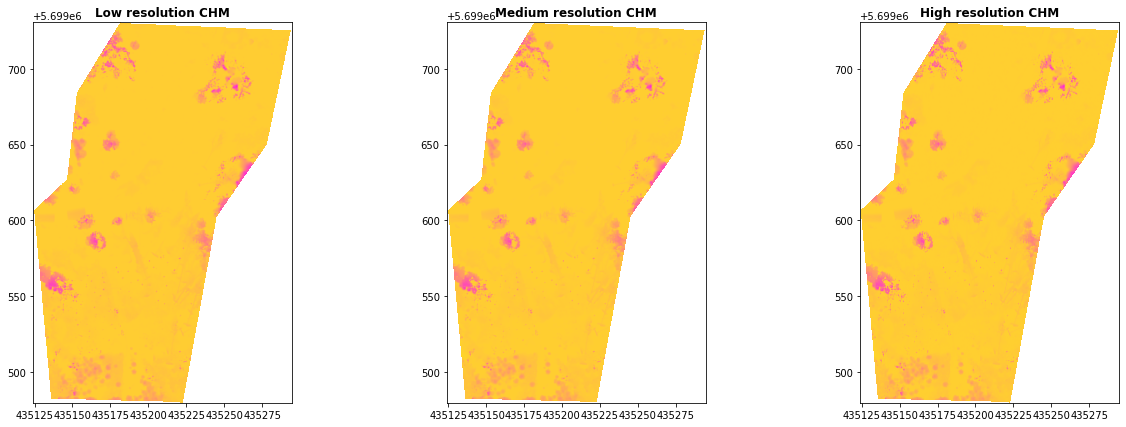

In [17]:
# Defining the folder where the image data are located (relative path)
folder = '../Images/'

# Read CHMs as rasterio object
chm_low = rio.open(folder + 'CHMs/CHM-100mm.tif')
chm_medium = rio.open(folder + 'CHMs/CHM-50mm.tif')
chm_high = rio.open(folder + 'CHMs/CHM-33mm.tif')

# Convert CHMs to numpy arrays
low_array = chm_low.read()
medium_array = chm_medium.read()
high_array = chm_high.read()

# Display CHMs
fig, (axr, axg, axb) = pyplot.subplots(1,3, figsize=(21,7))
show(chm_low, ax=axr, cmap='spring_r', title='Low resolution CHM')
show(chm_medium, ax=axg, cmap='spring_r', title='Medium resolution CHM')
show(chm_high, ax=axb, cmap='spring_r', title='High resolution CHM')
pyplot.show()

#### 2. Display metadata of the file

Differences:
- width:
    - Low:1705
    - Medium: 3411
    - High: 5065
- height:
    - Low:2508
    - Medium: 5016
    - High: 7449
- transform

In [6]:
print(chm_low.meta, "\n", chm_medium.meta, "\n", chm_high.meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 1705, 'height': 2508, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(0.1, 0.0, 435124.09857298504,
       0.0, -0.09999999999992573, 5699730.589859151)} 
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 3411, 'height': 5016, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(0.04999999999999659, 0.0, 435124.09857298504,
       0.0, -0.049999999999962866, 5699730.589859151)} 
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 5065, 'height': 7449, 'count': 1, 'crs': CRS.from_epsg(25832), 'transform': Affine(0.033666399999996065, 0.0, 435124.09857298504,
       0.0, -0.03366639999994589, 5699730.589859151)}


#### 3. Cropping the CHMs using a threshold value

In [18]:
# Give the path variables
paths = [folder + 'CHMs/CHM-33mm.tif', 
         folder + 'CHMs/CHM-50mm.tif',
         folder + 'CHMs/CHM-100mm.tif']

# Give the threshold values
thresholds = [0.05, 1, 5]

# Create empty arrays to store the CHMs and cropped arrays
rows, cols = (len(thresholds), len(paths))
cropped_arrays = [[0 for i in range(cols)] for j in range(rows)]
chms = [[0 for i in range(cols)] for j in range(rows)]

for row, threshold in enumerate(thresholds):
    for col, path in enumerate(paths):
        # Read the CHM into a rasterio object
        chm = rio.open(path)

        # Convert rasterio object to numpy array
        array = chm.read()

        # Crop numpy arrays based on a threshold value
        cropped = np.where(array > threshold, -32767.0, array)

        # Store cropped numpy array and original CHM in 2D lists
        cropped_arrays[row][col] = cropped
        chms[row][col] = chm

#### 4. Convert numpy arrays to tiff raster objects and save them

In [9]:
# Create output paths for saving the modified CHMs
output_paths = [folder + 'Height_cropping/High_resolution/',
                folder + 'Height_cropping/Medium_resolution/',
                folder + 'Height_cropping/Low_resolution/']
resolutions = ['high_', 'medium_', 'low_']

for row, threshold in enumerate(thresholds):
    for col, path in enumerate(output_paths):
        with rio.open(path + resolutions[col] + str(threshold) + ".tif", "w",
                driver= chms[row][col].driver,
                height= chms[row][col].height,
                width= chms[row][col].width,
                count= chms[row][col].count,
                dtype= "float32",
                crs= chms[row][col].crs,
                transform= chms[row][col].transform) as dst:
            dst.write(cropped_arrays[row][col])
            chms[row][col] = cropped_arrays[row][col]

#### 5. Display the resolution-threshold combinations

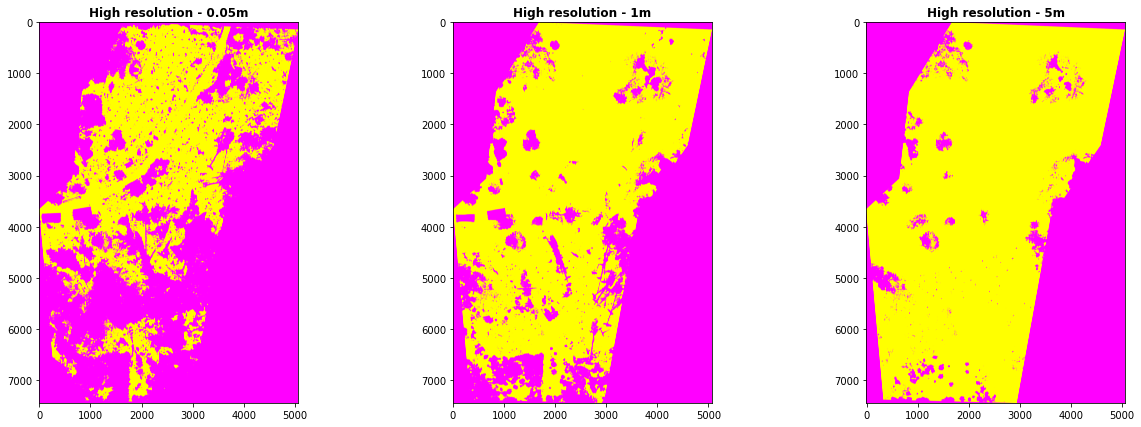

In [10]:
# Display CHMs
fig, (axr, axg, axb) = pyplot.subplots(1,3, figsize=(21,7))
show(chms[0][0], ax=axr, cmap='spring', title='High resolution - 0.05m')
show(chms[1][0], ax=axg, cmap='spring', title='High resolution - 1m')
show(chms[2][0], ax=axb, cmap='spring', title='High resolution - 5m')
pyplot.show()

#### 6. Use the numpy arrays as masks on the RGB orthophotos

In [12]:
# RGB orthomosaics
ortho_files = [folder + '/Orthomosaics/ortho-16mm.tif',
               folder + '/Orthomosaics/ortho-50mm.tif', 
               folder + '/Orthomosaics/ortho-100mm.tif']

cropped_rgb_arrays = [[0 for i in range(cols)] for j in range(rows)]
orthos = [[0 for i in range(cols)] for j in range(rows)]

for row, threshold in enumerate(thresholds):
    for col, path in enumerate(ortho_files):
        if col != 0:
            # Read the orthomosaic into a rasterio object
            rgb = rio.open(path)

            # Convert the raster object into a numpy array
            rgb_array = rgb.read()

            # Filter out the objects based on the mask
            cropped_rgb = np.where(cropped_arrays[row][col] == -32767.0, 0, rgb_array)
            
            cropped_rgb_arrays[row][col] = cropped_rgb
            orthos[row][col] = rgb

#### 7. Convert numpy arrays to tiff raster objects and save them

In [15]:
# Create output paths for saving the modified CHMs
output_paths = [folder + 'Height_cropping/High_resolution/', 
                folder + 'Height_cropping/Medium_resolution/', 
                folder + 'Height_cropping/Low_resolution/']
resolutions = ['ortho_high_', 'ortho_medium_', 'ortho_low_']

for row, threshold in enumerate(thresholds):
    for col, path in enumerate(output_paths):
        if col != 0:
            with rio.open(path + resolutions[col] + str(threshold) + ".tif", "w",
                    driver= orthos[row][col].driver,
                    height= orthos[row][col].height,
                    width= orthos[row][col].width,
                    count= orthos[row][col].count,
                    dtype= "float32",
                    crs= orthos[row][col].crs,
                    transform= orthos[row][col].transform) as dst:
                dst.write(cropped_rgb_arrays[row][col])

#### 8. Display the cropped RGB models

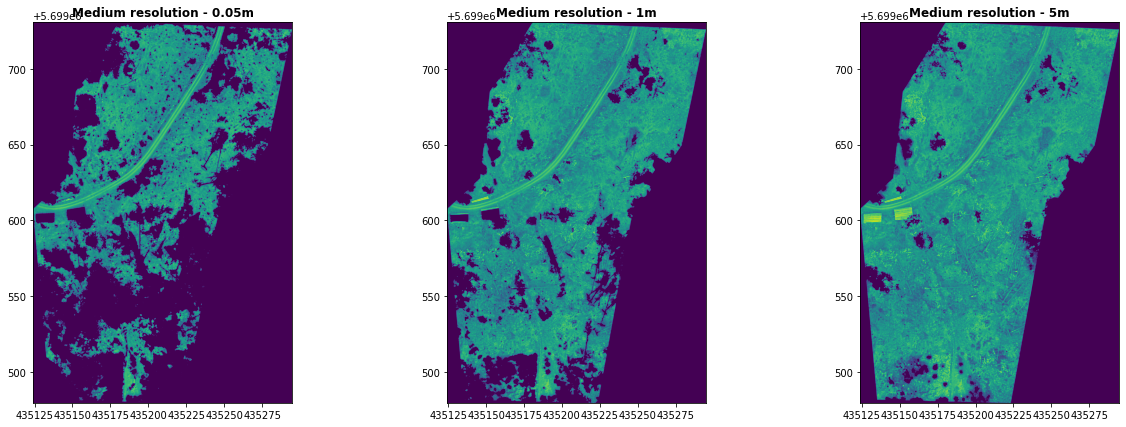

In [16]:
# Display orthos
fig, (axr, axg, axb) = pyplot.subplots(1,3, figsize=(21,7))
show(rio.open(folder + 'Height_cropping/Medium_resolution/ortho_medium_0.05.tif'), ax=axr, title='Medium resolution - 0.05m')
show(rio.open(folder + 'Height_cropping/Medium_resolution/ortho_medium_1.tif'), ax=axg, title='Medium resolution - 1m')
show(rio.open(folder + 'Height_cropping/Medium_resolution/ortho_medium_5.tif'), ax=axb, title='Medium resolution - 5m')
pyplot.show()